# V. Notebook : Calcul & visualisation des Greeks (Black–Scholes)

## Objectif
Calculer et illustrer les Greeks clés du modèle Black–Scholes :
- **Delta (Δ)** : sensibilité au sous-jacent
- **Vega (ν)** : sensibilité à la volatilité
- **Theta (Θ)** : sensibilité au temps (valeur / an)

**Hypothèses** : options européennes, marché frictionless, \( r \) et \( \sigma \) constants, pas de dividendes.
**Unités** : \( T \) en années ; \( r, \sigma \) en décimal. Theta renvoyée **par an**.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Affichage inline uniquement
%matplotlib inline

def _blocked_savefig(*args, **kwargs):
    raise RuntimeError("plt.savefig est bloqué (affichage inline uniquement).")
plt.savefig = _blocked_savefig

SEED = 42
np.random.seed(SEED)
    

## 5.1 Fonctions utilitaires de validation et de calcul (_validate_common, _validate_type, _d1_d2) 

**Explication :**
1) _validate_common() vérifie la validité des paramètres numériques : tous les prix doivent être positifs, le temps T non négatif et la volatilité σ ≥ 0.
2) _validate_type() contrôle que le type d’option est bien 'call' ou 'put'.
3) _d1_d2() calcule les coefficients d₁ et d₂ utilisés dans les formules de Black–Scholes, à partir des paramètres validés.
4) Ces fonctions sont utilitaires internes, utilisées par les pricers pour éviter la redondance et sécuriser les entrées.


**Pourquoi nous avons fait cela :** 
1) Centraliser les contrôles d’entrée pour rendre le code plus lisible et maintenable.
2) Garantir la stabilité numérique avant tout calcul (éviter divisions par zéro ou valeurs négatives).
3) Séparer la logique métier (calcul des prix) de la validation (qualité des données).
4) Faciliter la réutilisation des fonctions dans plusieurs notebooks sans duplication.

In [2]:
def _validate_common(S: float, K: float, T: float, r: float, sigma: float):
    if S <= 0: raise ValueError("S must be > 0")
    if K <= 0: raise ValueError("K must be > 0")
    if T < 0:  raise ValueError("T must be >= 0")
    if sigma < 0: raise ValueError("sigma must be >= 0")

def _validate_type(option_type: str):
    if option_type not in {"call", "put"}:
        raise ValueError("option_type must be 'call' or 'put'")

def _d1_d2(S: float, K: float, T: float, r: float, sigma: float):
    """Calcule d1, d2 (Black–Scholes). Supposé T>0 et sigma>0 (géré en amont)."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return d1, d2


## 5.2 Greeks (Δ, ν, Θ) — delta_bs, vega_bs, theta_bs

**Explication :**
1) Chaque fonction commence par valider les entrées via _validate_common et, si besoin, _validate_type.
2) Delta : retourne N(d1) pour un call et N(d1)−1 pour un put ; gère les limites T=0/σ=0 avec la convention ATM = 0.5.
3) Vega : calcule S * N'(d1) * √T (σ en décimal) ; renvoie 0 si T=0 ou σ=0 (pas d’incertitude → pas de sensibilité).
4) Theta (par an) : somme d’un terme diffusion (− S·N'(d1)·σ / (2√T)) et d’un terme de portage (± r K e^{-rT} N(±d2)) ; traite T=0 (θ=0) et σ→0 (ne garde que le portage).


**Pourquoi nous avons fait cela :** 
1) Obtenir des sensibilités analytiques fiables pour l’analyse des risques et la vérification par différences finies.
2) Sécuriser les bords (maturité, absence de volatilité) pour éviter NaN/∞ et coller aux limites théoriques.
3) Uniformiser les conventions : vega “par point” de σ (décimal) et theta par an pour des graphiques comparables.
4) Factoriser la logique (helpers + _d1_d2) pour un code maintenable et cohérent entre notebooks.

In [3]:
def delta_bs(S: float, K: float, T: float, r: float, sigma: float, option_type: str) -> float:
    """
    Delta (par unité de S). Call ∈ (0,1), Put ∈ (-1,0).
    """
    _validate_common(S, K, T, r, sigma); _validate_type(option_type)
    if T == 0 or sigma == 0:
        # Limites : à maturité / pas d'incertitude → delta 'saut' sur ITM/OTM
        # On adopte la convention suivante (limite théorique) :
        if option_type == "call":
            return 1.0 if S > K else (0.5 if S == K else 0.0)
        else:
            return 0.0 if S > K else (0.5 if S == K else -1.0)

    d1, d2 = _d1_d2(S, K, T, r, sigma)
    if option_type == "call":
        return float(norm.cdf(d1))
    else:
        return float(norm.cdf(d1) - 1.0)

def vega_bs(S: float, K: float, T: float, r: float, sigma: float) -> float:
    """
    Vega (variation de prix par point de sigma en décimal), par an.
    Formule : S * N'(d1) * sqrt(T). Toujours positive (sans dividendes).
    """
    _validate_common(S, K, T, r, sigma)
    if T == 0:
        return 0.0
    if sigma == 0:
        # Limite : si sigma→0, d1→±∞ sauf S≈K ; on renvoie 0 par défaut
        # (aucune incertitude → sensibilité nulle)
        return 0.0

    d1, _ = _d1_d2(S, K, T, r, sigma)
    return float(S * norm.pdf(d1) * np.sqrt(T))

def theta_bs(S: float, K: float, T: float, r: float, sigma: float, option_type: str) -> float:
    """
    Theta (variation du prix par an quand le temps passe).
    Convention : Theta 'par an' (pas par jour).
    Call : -(S * N'(d1) * sigma)/(2*sqrt(T)) - r K e^{-rT} N(d2)
    Put  : -(S * N'(d1) * sigma)/(2*sqrt(T)) + r K e^{-rT} N(-d2)
    """
    _validate_common(S, K, T, r, sigma); _validate_type(option_type)
    if T == 0:
        # À maturité, le temps ne 'passe' plus → theta = 0 (convention)
        return 0.0
    if sigma == 0:
        # Sans volatilité → la composante 'temps' via diffusion disparaît
        d1, d2 = _d1_d2(S, K, max(T, 1e-12), r, max(sigma, 1e-12))
        # La première partie tend vers 0 lorsque sigma→0
        if option_type == "call":
            return float(- r * K * np.exp(-r*T) * norm.cdf(d2))
        else:
            return float(+ r * K * np.exp(-r*T) * norm.cdf(-d2))

    d1, d2 = _d1_d2(S, K, T, r, sigma)
    first = - (S * norm.pdf(d1) * sigma) / (2.0 * np.sqrt(T))
    if option_type == "call":
        return float(first - r * K * np.exp(-r*T) * norm.cdf(d2))
    else:
        return float(first + r * K * np.exp(-r*T) * norm.cdf(-d2))


## 5.3 Définition des grilles de calcul des Greeks

**Explication :**
1) On fixe les paramètres de base du modèle
2) On crée trois grilles de valeurs pour analyser les variations des Greeks
3) Les pas sont choisis pour avoir des courbes lisses et comparables entre options call et put.


**Pourquoi nous avons fait cela :** 
1) Permettre une visualisation continue des Greeks sur des plages représentatives.
2) Faciliter l’analyse de sensibilité de chaque paramètre clé du modèle.
3) Fournir des entrées normalisées pour tracer des courbes interprétables (de 0 à 1 an, de 50 à 150, etc.).
4) Garantir la cohérence expérimentale entre les calculs des différents Greeks.


In [4]:
# Paramètres 'par défaut'
S0, K = 100.0, 100.0
r, sigma0 = 0.05, 0.2
T0 = 1.0

# Grilles
S_grid     = np.linspace(50, 150, 101)       # pour Delta(S)
sigma_grid = np.linspace(0.10, 0.50, 81)     # pour Vega(σ)
T_grid     = np.linspace(0.01, 1.00, 100)    # pour Theta(T)


**Graphique 1: Delta en fonction du sous-jacent**
- Le Delta du call (courbe bleue) croît de 0 à 1 : plus le sous-jacent augmente, plus l’option devient sensible au prix de l’actif.
- Le Delta du put (courbe orange) décroît de 0 à −1 : il réagit négativement aux hausses du sous-jacent.
- Les deux courbes se croisent à S = K = 100 où Δ𝑐𝑎𝑙𝑙 ≈ 0.5 Δcall ≈0.5 et Δ𝑝𝑢𝑡 ≈ −0.5 Δput​ ≈−0.5 — cas at-the-money (ATM).
- Les asymptotes montrent les comportements extrêmes :
    - Call saturant à 1 (quasi certain d’être exercé).
    - Put saturant à −1 (quasi sans valeur).


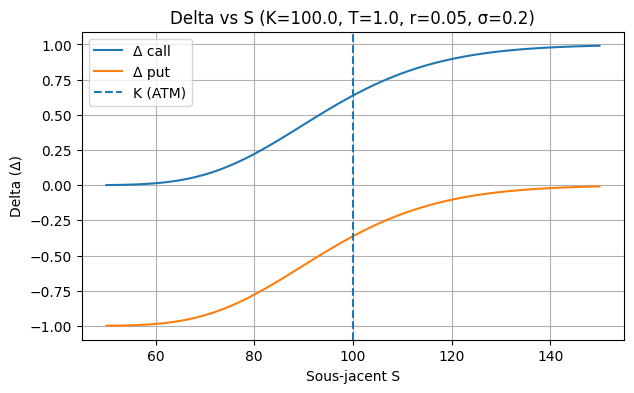

In [5]:
delta_call_vals = [delta_bs(S, K, T0, r, sigma0, "call") for S in S_grid]
delta_put_vals  = [delta_bs(S, K, T0, r, sigma0, "put")  for S in S_grid]

plt.figure(figsize=(7,4))
plt.plot(S_grid, delta_call_vals, label="Δ call")
plt.plot(S_grid, delta_put_vals,  label="Δ put")
plt.axvline(K, linestyle="--", label="K (ATM)")
plt.xlabel("Sous-jacent S")
plt.ylabel("Delta (Δ)")
plt.title(f"Delta vs S (K={K}, T={T0}, r={r}, σ={sigma0})")
plt.grid(True)
plt.legend()
plt.show()


**Graphique 2: Vega en fonction de la volatilité**
- Le Vega augmente rapidement avec la volatilité au début, puis atteint un maximum autour de σ ≈ 0.25.
- Au-delà de ce point, il diminue légèrement : les variations supplémentaires de volatilité ont un impact moindre sur le prix de l’option.
- Le pic correspond à un sous-jacent proche du strike (ATM), où le Vega est maximal.
- Cela montre que les options ATM sont les plus sensibles aux changements de volatilité.


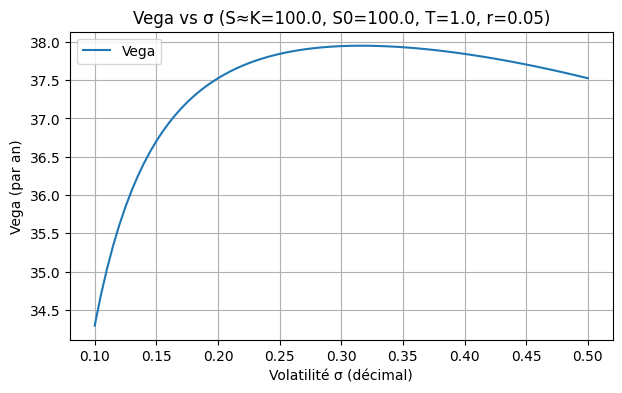

In [6]:
vega_vals = [vega_bs(S0, K, T0, r, s) for s in sigma_grid]

plt.figure(figsize=(7,4))
plt.plot(sigma_grid, vega_vals, label="Vega")
plt.xlabel("Volatilité σ (décimal)")
plt.ylabel("Vega (par an)")
plt.title(f"Vega vs σ (S≈K={K}, S0={S0}, T={T0}, r={r})")
plt.grid(True)
plt.legend()
plt.show()


**Graphique 3: Theta en fonction de la maturité**
- Le Theta est toujours négatif : la valeur de l’option diminue avec le temps.
- L’effet du temps est plus fort à court terme : la pente est très raide quand T est proche de 0.
- Le call (bleu) a un Theta plus négatif que le put (orange), car la composante de portage réduit la perte du put.
- À mesure que la maturité augmente, les deux courbes se stabilisent vers 0 : l’érosion temporelle devient plus lente.



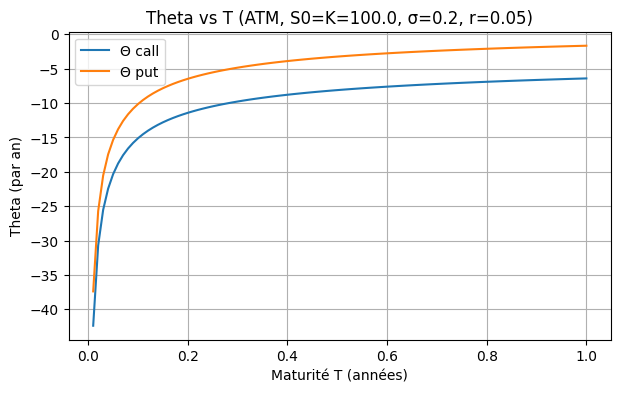

In [7]:
theta_call_vals = [theta_bs(S0, K, t, r, sigma0, "call") for t in T_grid]
theta_put_vals  = [theta_bs(S0, K, t, r, sigma0, "put")  for t in T_grid]

plt.figure(figsize=(7,4))
plt.plot(T_grid, theta_call_vals, label="Θ call")
plt.plot(T_grid, theta_put_vals,  label="Θ put")
plt.xlabel("Maturité T (années)")
plt.ylabel("Theta (par an)")
plt.title(f"Theta vs T (ATM, S0=K={K}, σ={sigma0}, r={r})")
plt.grid(True)
plt.legend()
plt.show()
